In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.linear_model import LogisticRegression

## Functions

In [2]:
def get_beta_dist(arm):
    tot = counts['reward']['count'].loc[counts.index == arm]
    conv = counts['reward']['sum'].loc[counts.index == arm]
    return(pd.DataFrame({'action' : arm, 
                         'x' : xrange, 
                         'y' : beta.pdf(xrange, 1 + conv, 1 + tot - conv)}))


def plot_beta_dist_by_action(arm):
    df = beta_dist_by_action.loc[beta_dist_by_action.action == arm]
    plt.plot(df['x'], df['y'])
    

def train_model_by_action(arm):
    df = data.loc[data.action == arm]
    X = df[xnames]
    y = df['reward']
    return(LogisticRegression().fit(X, y))


def pred_reward_actual_action(arm):
    df = data.loc[data.action == arm]
    return(pd.DataFrame({'id' : df.index, 'action' : arm, 'pred_reward_for_actual_action' : pd.Series(models_list[arm - 1].predict_proba(df[xnames])[:,1])}).set_index('id'))


def get_policy_beta(pol, num_conv):
    return(pd.DataFrame({'policy' : pol, 'x' : xrange, 'y' : beta.pdf(xrange, 1 + num_conv, 1 + len(data) - num_conv)}))


def plot_beta_dist_by_policy(pol):
    df = all_betas.loc[all_betas.policy == pol]
    plt.plot(df['x'], df['y'])
    
    
def get_pred_reward_for_proposed_action(arm):
    dm_rewards.loc[dm_rewards.proposed_action == arm, 'pred_reward_for_proposed_action'] = dm_rewards['r' + str(arm)]    
    
    
def get_propensities(arm):
    ips_rewards.loc[ips_rewards.proposed_action == arm, 'propensity'] = propensities[arm]    

## Load data

In [3]:
url = 'http://d1ie9wlkzugsxr.cloudfront.net/data_cmab_basic/dataset.txt'

xnames = ['x' + str(i) for i in list(np.arange(1, 101))]
names = ['action', 'reward'] + xnames + ['empty_col']

data = pd.read_csv(url, sep= ' ', header=None, names=names).drop('empty_col', axis=1)
data.shape
data.index.rename('id')

RangeIndex(start=0, stop=10000, step=1, name='id')

In [4]:
data.head()

,action,reward,x1,x2,x3,x4,x5,x6,x7,x8,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,2,0,5,0,0,37,6,0,0,0,...,0,0,1,3,0,0,17,30,4,0
1,8,0,1,3,36,0,0,0,0,0,...,0,0,3,0,1,5,1,0,0,10
2,5,0,3,0,0,0,0,0,0,0,...,0,0,0,0,23,0,11,3,0,0
3,4,0,77,0,0,13,0,0,0,0,...,0,5,0,0,0,2,4,0,0,0
4,2,1,43,0,2,44,1,0,0,0,...,0,0,0,0,0,0,0,13,0,0


## Summarise data

In [5]:
data['action'].value_counts(normalize=True).sort_index()

1     0.1020
2     0.0982
3     0.0974
4     0.1047
5     0.1005
6     0.0963
7     0.1035
8     0.0999
9     0.0988
10    0.0987
Name: action, dtype: float64

In [6]:
data['reward'].value_counts(normalize=True)

0    0.8961
1    0.1039
Name: reward, dtype: float64

### Actual conversion rate

In [7]:
data['reward'].sum() /  len(data)

0.1039

### Action propensities

In [8]:
propensities = data['action'].value_counts(normalize=True).sort_index()

### Action pool

In [9]:
arms = sorted(data['action'].unique())

## Beta distributions per action for original policy

In [10]:
xrange = np.linspace(0, 0.3, 1001)
counts = data.groupby('action').agg({'reward': ['count', 'sum']})

In [11]:
beta_dist_by_action = pd.concat([get_beta_dist(a) for a in arms])

[None, None, None, None, None, None, None, None, None, None]

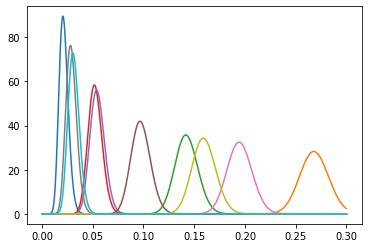

In [12]:
[plot_beta_dist_by_action(a) for a in arms]

## Define a proposed policy
### Choose randomly from actions 1-5 only

In [13]:
np.random.seed(666)
proposed_policy = pd.Series(np.random.randint(1, 6, size=len(data)))
proposed_policy.rename('proposed_action', inplace=True)

0       5
1       3
2       2
3       5
4       4
       ..
9995    4
9996    2
9997    3
9998    1
9999    1
Name: proposed_action, Length: 10000, dtype: int64

## Fit a model to each action

In [14]:
models_list = [train_model_by_action(a) for a in arms]

## Predict reward for every action

In [15]:
pred_action_reward_list = [pd.Series(models_list[i].predict_proba(data[xnames])[:,1]) for i in np.arange(0, 10)]
pred_action_reward = pd.concat(pred_action_reward_list, axis=1)
pred_action_reward.columns = ['r' + str(i) for i in list(np.arange(1, 11))]

## Predict reward for actual action

In [16]:
pred_actual_reward = pd.concat([pred_reward_actual_action(a) for a in arms]).sort_index()

## Direct method

In [17]:
dm_rewards = pd.concat([proposed_policy, pred_action_reward], axis=1)

dm_rewards['pred_reward_for_proposed_action'] = np.nan
[get_pred_reward_for_proposed_action(a) for a in arms]

[None, None, None, None, None, None, None, None, None, None]

### DM conversion rate

In [18]:
round(dm_rewards['pred_reward_for_proposed_action'].sum() / len(data), 3)

0.1

## Inverse propensity scores

In [19]:
ips_rewards = pd.concat([data[['action', 'reward']], proposed_policy], axis=1)
ips_rewards.columns = ['actual_action', 'actual_reward', 'proposed_action']

ips_rewards['propensity'] = np.nan
[get_propensities(a) for a in arms]

ips_rewards['weighted_reward'] = 0
ips_rewards.loc[ips_rewards.actual_action == ips_rewards.proposed_action, 'weighted_reward'] = ips_rewards['actual_reward'] / ips_rewards['propensity']

### IPS conversion rate

In [20]:
round(ips_rewards['weighted_reward'].sum() / len(data), 3)

0.105

## Doubly robust

In [21]:
dr_rewards = pd.concat([dm_rewards[['proposed_action', 'pred_reward_for_proposed_action']], 
                        ips_rewards[['actual_action', 'actual_reward', 'propensity']],
                        pred_actual_reward['pred_reward_for_actual_action']], axis=1)

dr_rewards['reward_diff'] = dr_rewards['actual_reward'] - dr_rewards['pred_reward_for_actual_action']

dr_rewards['weighted_reward_diff'] = 0
dr_rewards.loc[dr_rewards.actual_action == dr_rewards.proposed_action, 'weighted_reward_diff'] = dr_rewards['reward_diff'] / dr_rewards['propensity']

dr_rewards['dr_result'] = dr_rewards['pred_reward_for_proposed_action'] + dr_rewards['weighted_reward_diff']

### DR conversion rate

In [22]:
round(dr_rewards['dr_result'].sum() / len(data), 3)

0.1

## Compare conversion rates of actual and proposed policies
DM/IPS/DR results are conversion rate estimates of the proposed policy. These estimates can be compared to the conversion rate of the actual policy.

In [23]:
beta_actual = get_policy_beta('Actual', num_conv = data['reward'].sum())

beta_proposed_dm = get_policy_beta('Proposed (dm)', num_conv = dm_rewards['pred_reward_for_proposed_action'].sum())

beta_proposed_ips = get_policy_beta('Proposed (ips)', num_conv = ips_rewards['weighted_reward'].sum())

beta_proposed_dr = get_policy_beta('Proposed (dr)', num_conv = dr_rewards['dr_result'].sum())

all_betas = pd.concat([beta_actual, beta_proposed_dm, beta_proposed_ips, beta_proposed_dr])

[None, None]

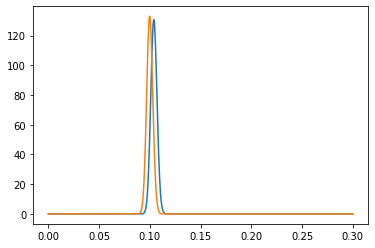

In [24]:
[plot_beta_dist_by_policy(p) for p in ['Actual', 'Proposed (dr)']]